# **LSTM and GRU Demo**


Vanilla RNNs work well when dealing with short-term dependencies but suffer from the vanishing gradient descent problem when it comes to long-term context dependencies. This is because some information is lost at each time step when traversing the layers. Gated RNNs have units that are designed to forget and to update relevant information and can provide a good solution to this problem. In this lab, we will talk about two types of gated RNNs: LSTM and GRUs.


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#Gated-RNNs">Gated RNNs</a>
        <ol>
            <li><a href="#LSTM">LSTM</a></li>
            <li><a href="#GRU">GRU</a></li>
            <li><a href="#LSTM in Keras: Time-series forecasting">LSTM in Keras: Time-series forecasting</a></li>
            <li><a href="#Exercise 1: GRU in Keras - Reuters classification">Exercise 1: GRU in Keras - Reuters classification</a></li>
        </ol>
    </li>


## Objectives

After completing this lab, you will be able to:

 - Explain the fundamental components of LSTM and GRU
 - Implement LSTM and GRU in Keras for various tasks and applications


----


## Setup


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run these notebook commands in a different Jupyter environment (like Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the following code cell.


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [1]:
%%capture

!mamba install -qy tqdm
!pip install tensorflow --upgrade

### Importing Required Libraries


In [ ]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
print(tf. __version__)

from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding,Masking,LSTM, GRU, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN
from tensorflow.keras.datasets import reuters
from keras.utils import pad_sequences


sns.set_context('notebook')
sns.set_style('white')
np.random.seed(2024)


## Gated RNN

The two types of gated RNNs we will be studying in this lab are Long Short Term Memories (LSTM) and Gated Recurrent Units (GRU). GRU is simpler than LSTM. It's much faster and optimizes quicker. 

### LSTM

The key idea of LSTMs is to have two state representations: the hidden state $\mathbf h$ and the cell state $\mathbf C$ (instead of $\mathbf s$). 

An LSTM cell has a complex internal structure that makes it able to:

* learn to recognize an important input,
* store it in the long-term state,
* preserve it for as long as it is needed,
* extract it whenever it is needed.

<img src="https://wiki.math.uwaterloo.ca/statwiki/images/thumb/9/98/LSTM.png/800px-LSTM.png" alt="Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/" style="width: 500px;"> 

Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

LSTM has the ability to remove or add information to the cell state, carefully regulated by structures called gates, which are a way to optionally let information through. There are three gates in an LSTM; forget gate, input gate, and output gate. They are composed out of a *sigmoid* neural net layer. Sigmoid-based layers output values near either 0 (gate closed) or 1 (gate open).


### GRU

GRU is a simplification of the LSTM cell that performs similarly well while being faster to train. It has a single update gate controller that manages both the forget and input gates. Whenever one is open, the other is closed. There is no output gate. The reset gate controls which part of the previous state is shown to the main layer. The resulting model is simpler than standard LSTM models. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize.

<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/gru.png?raw=1" alt="Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/" style="width: 300px;"> 


### LSTM in Keras: Time-series forecasting


Next, we will build a simple LSTM model to solve a many-to-one time-series prediction problem on a simulated sine wave.


Let's first start by generating some sine waves using the `np.sin()` function.


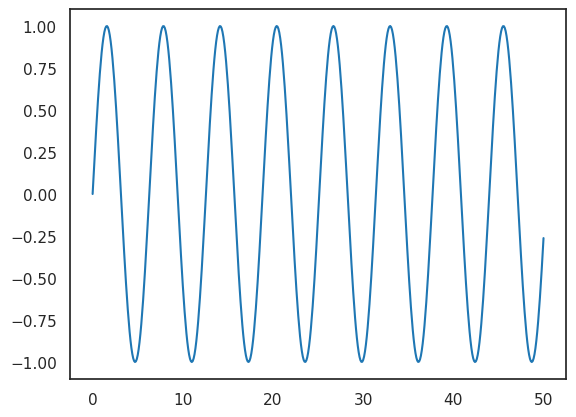

In [2]:
x = np.linspace(0, 50, 501)
y = np.sin(x)
plt.plot(x, y)

We will convert this into a data frame for convenience.


In [3]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])

We are dealing with a univariate time series, so we have a total of one feature. We will be using 10% of the simulated data for testing.


In [4]:
# percentage of data used for testing
test_percent = 0.1
# number of features
n_features = 1
# sequence length
length = 50
# batch size 
batch_size = 1

Let us now create a training and testing dataset to train and test our model on.


In [5]:
test_point = np.round(len(df)*test_percent)
test_ind = int(len(df)-test_point)

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

We will perform some basic preprocessing using the `MinMaxScaler`, which normalizes the input.


In [6]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

`TimeseriesGenerator` is a utility class by Keras that is used in generating batches of temporal data. Given our scaled training data, we create 401 output sequences.


In [7]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
len(generator)

401

We will use the `LSTM()` layer with 50 units, and an input shape defined by the sequence length and number of features.


In [ ]:
model = Sequential()

model.add(LSTM(50, input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [9]:
model.fit_generator(generator, epochs=6)

Epoch 1/6
401/401 [==============================] - 15s 33ms/step - loss: 0.0104
Epoch 2/6
401/401 [==============================] - 15s 37ms/step - loss: 4.0279e-05
Epoch 3/6
401/401 [==============================] - 14s 35ms/step - loss: 9.8503e-05
Epoch 4/6
401/401 [==============================] - 13s 32ms/step - loss: 4.6717e-04
Epoch 5/6
401/401 [==============================] - 14s 35ms/step - loss: 5.0995e-05
Epoch 6/6
401/401 [==============================] - 15s 37ms/step - loss: 7.0689e-05


We will now evaluate the LSTM's performance in forecasting a few time steps from the first batch.


In [10]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(25):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 30ms/step


We will invert the min-max scaling on the predictions to allow for a direct comparison with the ground truth.


In [11]:
forecast = scaler.inverse_transform(forecast)

In [12]:
forecast_index = np.arange(50.1, 52.6, step=0.1)

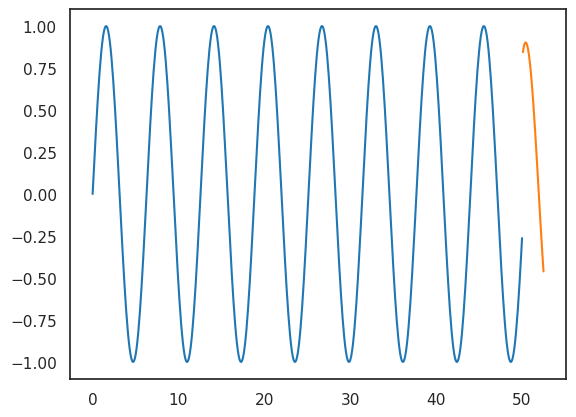

In [13]:
plt.plot(df.index, df['Sine'])
plt.plot(forecast_index, forecast)

### Exercise 1: GRU in Keras - Reuters classification

In this exercise, you will use the reuters dataset from Keras that we imported earlier to build a classification model using GRUs.


The dataset used is the Reuters newswire dataset from Keras. We have 11,228 newswires from Reuters, labeled over 46 topics.

> Each newswire is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

It returns the following:

> x_train, x_test: lists of sequences, which are lists of indexes (integers). If the num_words argument was specific, the maximum possible index value is num_words - 1.


Let us start by defining a few hyperparameters. 

* We use 10,000 to specify `num_words`, that is, the maximum possible index value loaded is `num_words` - 1. 

* Input length of the embedding layer is specified using `maxlen`

* We will use 30% of the data for testing.


In [ ]:
# Hyperparameters
num_words = 10000
maxlen = 1000
test_split = 0.3

Next, we will use the Keras API to load in our reuters dataset.


In [ ]:
# Load reuters Data from Keras datasets
(X_train, y_train),(X_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.3)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')


In terms of pre-processing, we pad sequences to the same length using `pad_sequences`. Sequences longer than `num_timesteps` are truncated so that they fit the desired length. Whereas sequences that are shorter than `num_timesteps` are padded with value until they are `num_timesteps` long.


In [ ]:
# data preprocessing
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


y_train = tf.keras.utils.to_categorical(y_train, 46)
y_test = tf.keras.utils.to_categorical(y_test, 46)

Start by defining the model architecture. Use a `GRU` layer with 128 units, and a dropout rate of 0.2. Use a dense layer with 46 units and softmax as the activation function. Print out the model summary.


In [ ]:
# Write your solution here


<details>
    <summary>Click here for Solution</summary>
   
```python
model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 300,input_length=1000))
model.add(GRU(128, dropout=0.2))
model.add(Dense(46, activation='softmax'))
model.summary()
```
</details>


Now compile the model using categorical_crossentropy as the loss function, adam as the optimizer and accuracy as the metric. Train the model using 256 as the batch size, over 10 training iterations and using 20% of the data for validation purposes. Finally, evaluate the model's performance on the test dataset.


In [ ]:
# Write your solution here


<details>
    <summary>Click here for Solution</summary>
   
```python
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, y_train,batch_size=256,epochs=10,validation_split=0.2)
model.evaluate(X_test,y_test)
```
</details>
